In [2]:
from skimage.color import rgb2hsv
from skimage.filters import gaussian
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import openslide as os
import pandas as pd
import numpy as np
import glob
import math
import cv2

from pathlib import Path
from collections import Counter
from skimage import color, filters, morphology
from PIL import Image, ImageDraw, ImageFilter
Image.MAX_IMAGE_PIXELS = None
from multiprocessing import Pool, cpu_count

# LOGGING #

In [3]:
import logging
import datetime
import sys


def prepare_logger(logger, level=logging.DEBUG):
    
    def prepare_handler(handler):
        handler.setLevel(level)
        handler.setFormatter(formatter)
        return handler

    formatter = logging.Formatter(fmt='%(asctime)s | [%(levelname)s] %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')

    del logger.handlers[:]
    logger.handlers.append(prepare_handler(logging.StreamHandler(sys.stderr)))

    logger.setLevel(level=level)
    return logger

logg = logging.getLogger()
logg = prepare_logger(logg)

# ANNOTATION MASKING #

In [4]:
def read_polygons(annotation_filepath, scale_factor):
    """
        Utility function to read an annotation XML file and create a list of vertices for
        polygon delimiting the cancerous area.
    """
    tumor_keywords = ['Metastasis', 'Carcinoma', 'Tumor', 'Rough tumor']
    # Read cancer polygon area
    polygons = []
    root = ET.parse(str(annotation_filepath)).getroot()
    for anno_tag in root.findall('Annotations/Annotation'):
        polygon = []

        if anno_tag.get('PartOfGroup') not in tumor_keywords:
            continue

        for coord in anno_tag.findall('Coordinates/Coordinate'):
            polygon.append((float(coord.get('X')) / scale_factor,
                            float(coord.get('Y')) / scale_factor))
        polygons.append(polygon)
    return polygons


def create_annotation_mask(annot_file, size, scaling_factor=1):
    """
        Creates a binary mask for the cancer area (white) from annotation file
    """
    logg.info('Creating annotation mask.')
    label_mask = Image.new(
        'L', size=size, color='BLACK')
    label_draw = ImageDraw.Draw(label_mask)
    polygons = read_polygons(annot_file, scaling_factor)
    for polygon in polygons:
        label_draw.polygon(xy=polygon, outline=(255), fill=(255))
    return label_mask

# BACKGROUND MASKING #

In [5]:
def check_tile_background(tile):
    """ 
        Camelyon style background filter.
        Originally, the function should be applied on each tile individually. This, however, requires
        that each tile be extracted and read from the slide.
    """
    hsv_img = rgb2hsv(tile.convert('RGB'))
    blurred_hsv_img = gaussian(hsv_img, multichannel=True)
    return np.max(blurred_hsv_img[:, :, 1]) < 0.07

# UTILITY FUNCTIONS #

In [6]:
def calculate_progress(y_coord, x_coord, slide_width, slide_height, center_size, old_percentage):
    """
        Calculate progress as a ratio of processed slide area vs total slide area
    """
    total = slide_height*slide_width
    processed = (y_coord*slide_width + center_size*x_coord)
    percentage = int(processed / total * 100)

    if percentage > old_percentage:
        print('Progress: {:3}%\r'.format(percentage), end='')
    
    return percentage

# MAIN CODE #

In [ ]:
def process_wsi(slide_fn, annot_fn,                                   # FILE PATHS
                center_size, margin_size,                             # TILE SPECIFICATIONS
                tile_downsample=1,                                    # EXTRACTION PROPERTIES
                background_threshold=0.2, cancer_threshold=1):        # THRESHOLDS
    """
        Process each tile from WSI

        1) Get handler for WSI slide
        2) Create black & white annotation mask (WSI size)
        3) Create black & white background mask (downsized)
        4) For each column and row
            4.1) Retrieve tile from scaled down background mask
            4.2) If tile is NOT background, retrieve center of the tile from the annotation mask
            4.3) Label and add it to the table
    """
    percent = -1

    tile_size = center_size + 2*margin_size

    logg.info('Opening original slide')
    slide = os.open_slide(slide_fn)

    tile_level = slide.get_best_level_for_downsample(tile_downsample)
    tile_downsample = slide.level_downsamples[tile_level]
    slide_width, slide_height = slide.level_dimensions[tile_level]

    logg.debug('Downsampled slide dimensions: (w:{}, h:{})'.format(
        slide_width, slide_height))
    logg.debug('Sampling level: {}'.format(tile_level))
    logg.debug('Downsampling factor: {}'.format(tile_downsample))

    annotation_mask = create_annotation_mask(
        annot_fn, size=(slide_width, slide_height), scaling_factor=tile_downsample)

    logg.info('Initializing offset map')
    offset_map = {'row': [], 'col': [], 'class': []}

    logg.info('Processing WSI tiles.')
    for row, y_coord in enumerate(range(0, slide_height, center_size), 1):
        for col, x_coord in enumerate(range(0, slide_width, center_size), 1):

            # CALCULATE PROGRESS
            percent = calculate_progress(
                y_coord, x_coord, slide_width, slide_height, center_size, percent)

            # BACKGROUND CHECK
            # - retrieve tile from slide
            tile = slide.read_region(location=(
                x_coord*tile_downsample, y_coord*tile_downsample), level=tile_level, size=(tile_size, tile_size))
            
            
            tile_mask = background_mask.crop((scale(x_coord), scale(y_coord),
                                              scale(x_coord+tile_size), scale(y_coord+tile_size)))

            # SKIP IF TILE IS BACKGROUND
            if tissue_percent(np.array(tile_mask), scale(tile_size)) < background_threshold:
                continue

            # RETRIEVE CENTER REGION OF A TILE FROM CANCER MASK
            tile_mask = annotation_mask.crop((x_coord+margin_size, y_coord+margin_size,
                                              x_coord+margin_size+center_size, y_coord+margin_size+center_size))

            # TILE IS CANCER IF AT LEAST 1 PIXEL IN CENTER IS CANCEROUS
            class_ = 0
            if np.count_nonzero(np.array(tile_mask)) >= cancer_threshold:
                class_ = 1

            offset_map['row'].append(row)
            offset_map['col'].append(col)
            offset_map['class'].append(class_)

    offset_df = pd.DataFrame.from_dict(offset_map)
    offset_df.set_index(['col', 'row'], inplace=True)
    return offset_df

# MAIN LOGIC #

In [ ]:
from multiprocessing import Pool


def worker_task(slide_fn, annot_fn, output_fn, center_size, margin_size, level, downsample, background_threshold, cancer_threshold):
    try:
        logg.info(slide_fn)
        offset_df = process_wsi(slide_fn=slide_fn, annot_fn=annot_fn,
                                center_size=center_size, margin_size=margin_size,
                                level=level, downsample=downsample, background_threshold=0.2,
                                cancer_threshold=1)
        logg.info('Retrieved {} tiles.'.format(len(offset_df)))
        offset_df.to_pickle(output_fn, compression='gzip')
        return True
    except:
        logg.error('Exception occurred for slide: {}'.format(slide_fn))
        return False


def main():
    log = logging.getLogger()
    log = prepare_logger(log, level=logging.INFO, filename_template=None)

    level = 0
    downsample = 32
    center_size = 32
    margin_size = 32
    tile_size = center_size + 2*margin_size

    DATASET_NAME = 'Mammy'

    MRXS_DATASET = '/mnt/data/scans/AI scans/{ds_name}/'.format(
        ds_name=DATASET_NAME)
    ANNOT_DIR = '/home/matejg/rough/'
    OUTPUT_DIR = Path(
        '/home/matejg/wsi_maps/Mammy/level{level}/normal/'.format(level=level))

    if not OUTPUT_DIR.exists():
        logg.debug('Creating output directory.')
        OUTPUT_DIR.mkdir(parents=True)

    with Pool(processes=None) as pool:

        for slide_fn in Path(MRXS_DATASET).glob('*.mrxs'):
            annot_fn = (Path(ANNOT_DIR) / slide_fn.name).with_suffix('.xml')
            output_fn = OUTPUT_DIR / '{slide_name}-level{level}-ds{downsample}-tile{tile_size}-center{center_size}.gz'.format(
                slide_name=slide_fn.stem, level=level, downsample=downsample, tile_size=tile_size, center_size=center_size)

            if annot_fn.exists():
                pool.apply_async(worker_task, (str(slide_fn), str(annot_fn), str(
                    output_fn), center_size, margin_size, level, downsample, background_threshold, cancer_threshold))
            else:
                logg.warning(
                    '{} skipped. No annotation XML found.'.format(slide_fn.stem))

# EXECUTOR #

In [ ]:
if __name__ == '__main__':
    main()

# TESTING SPACE #

2019-08-27 12:50:07 | [DEBUG] update_title_pos
2019-08-27 12:50:07 | [DEBUG] update_title_pos
2019-08-27 12:50:08 | [DEBUG] update_title_pos
2019-08-27 12:50:08 | [DEBUG] update_title_pos
2019-08-27 12:50:08 | [DEBUG] update_title_pos
2019-08-27 12:50:09 | [DEBUG] update_title_pos
2019-08-27 12:50:09 | [DEBUG] update_title_pos
2019-08-27 12:50:09 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:10 | [DEBUG] update_title_pos
2019-08-27 12:50:11 | [DEBUG] update_title_pos


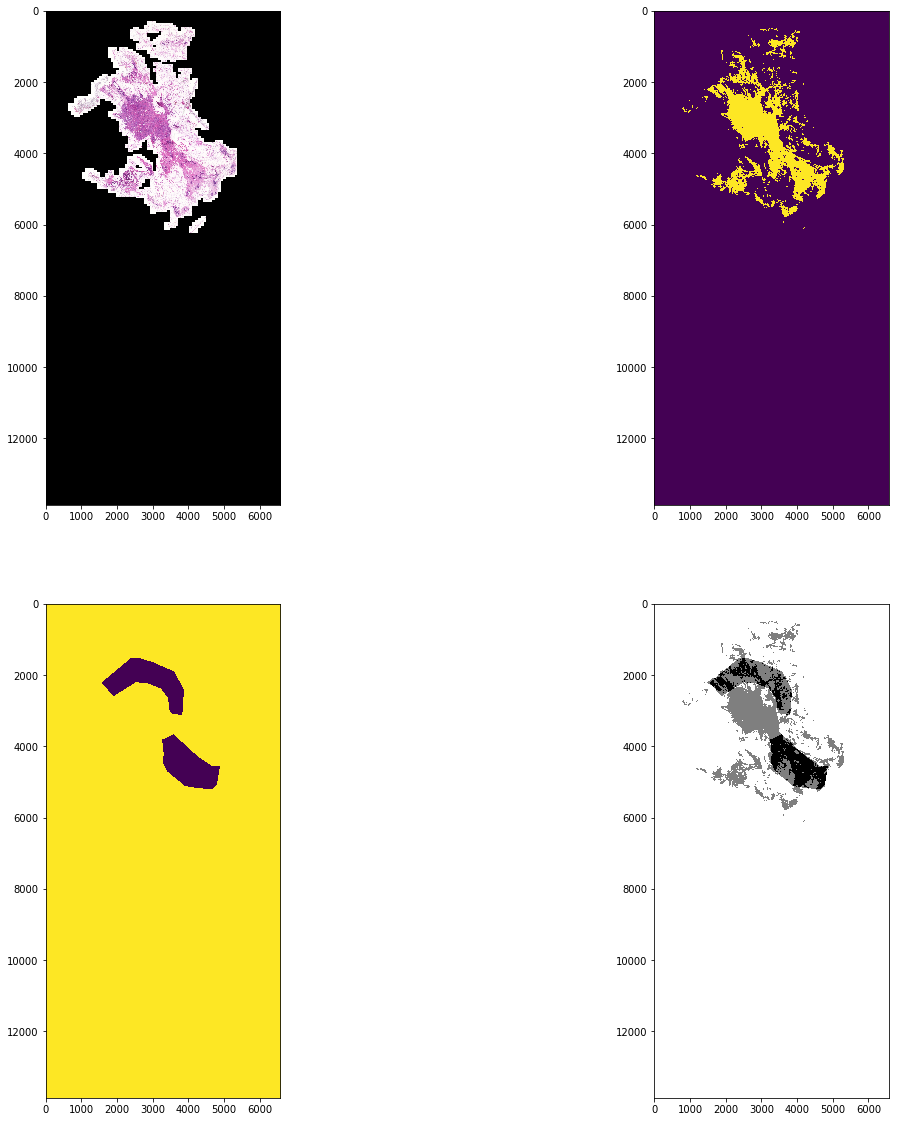

In [91]:
fig1 = plt.figure(figsize=(20,20))
ax1 = fig1.add_subplot(2,2,1)
ax1.imshow(slide_img)

ax2 = fig1.add_subplot(2,2,2)
ax2.imshow(mask)

ax3 = fig1.add_subplot(2,2,3)
ax3.imshow(breast_mask)

ax4 = fig1.add_subplot(2,2,4)
ax4.imshow(super_mask)

In [17]:
def create_dir(dir_path):
    """ Creates a directory if does not exist already"""
    if not dir_path.exists():
        dir_path.mkdir(parents=True)

def get_xml_dir(tissue_type, rough=False):
    if tissue_type == 'Mammy':
        return Path('/home/matejg/rough/')
    return Path('/mnt/data/scans/AI scans/{}/'.format(tissue_type))
     
def create_bg_mask(slide, bg_level, disk=10):
    logg.debug('Retrieving scaled down slide image.')
    slide_img = slide.read_region(location=(0,0), level=bg_level, size=slide.level_dimensions[bg_level]).convert('RGB')   
    logg.debug('Converting image to HSV.')
    slide_hsv = color.rgb2hsv(slide_img)
    logg.debug('Saturating')
    saturation = slide_hsv[:,:,1]
    logg.debug('Thresholding')
    threshold = filters.threshold_otsu(saturation)
    logg.debug('Thresholding saturation')
    high_saturation = (saturation > threshold)
    logg.debug('Creating disk')
    disk_object = morphology.disk(disk)
    logg.debug('Closing disk')
    mask = morphology.closing(high_saturation, disk_object)
    logg.debug('Opening disk')
    mask = morphology.opening(mask, disk_object)
    logg.debug('DONE')
    return Image.fromarray(mask)    
    
def get_slide_level_info(slide, magnification, zero_magnification=20):
    
    if zero_magnification is None:
        logg.debug('Zero magnification unspecificied. Reading from slide properties.')
        zero_magnification = int(slide.properties['openslide.objective-power'])
        
    level = slide.get_best_level_for_downsample(zero_magnification / magnification)
    scale_factor = slide.level_downsamples[level]
    logg.debug('Level {} scaling: {}'.format(level, scale_factor))

    bg_level = slide.get_best_level_for_downsample(zero_magnification / 1.25)
    bg_scale_factor = slide.level_downsamples[bg_level]

    logg.debug('BG Level {} scaling: {}'.format(bg_level, bg_scale_factor))
    logg.debug('Effective scaling: {}'.format(bg_scale_factor / scale_factor))
    return level, scale_factor, bg_level, bg_scale_factor

def read_polygons(annotation_filepath, scale_factor, mark_tumor=True):
    """
        Utility function to read an annotation XML file and create a list of vertices for
        polygon delimiting the cancerous area.
    """    
    if mark_tumor:
        exclude_keywords = ['Breast', 'Rough not-tumor']
    else:
        exclude_keywords = ['Metastasis', 'Carcinoma', 'Tumor', 'Rough tumor'] 
        
    # Read cancer polygon area
    polygons = []
    root = ET.parse(annotation_filepath).getroot()
    for anno_tag in root.findall('Annotations/Annotation'):
        polygon = []

        if anno_tag.get('PartOfGroup') in exclude_keywords:
            continue

        for coord in anno_tag.findall('Coordinates/Coordinate'):
            polygon.append((float(coord.get('X')) / scale_factor,
                            float(coord.get('Y')) / scale_factor))
        polygons.append(polygon)
    return polygons

def tissue_percent(tile_mask, tile_size):
    """
        Calculates the fraction of non-black area vs total area in a mask
    """
    ts_count = np.count_nonzero(tile_mask)
    bg_count = tile_size*tile_size
    return ts_count / bg_count

def get_annotation_mask(annot_file, mark_tumor, size, scaling_factor=1, bg_color='WHITE', poly_color='BLACK'):
    """
        Creates a binary mask for the cancer area (white) from annotation file
    """
    logg.info('Creating {} mask.'.format('cancer' if mark_tumor else 'exclusion'))
    label_mask = Image.new(
        'L', size=size, color=bg_color)
    label_draw = ImageDraw.Draw(label_mask)
    polygons = read_polygons(annot_file, scaling_factor, mark_tumor)
    for polygon in polygons:
        label_draw.polygon(xy=polygon, outline=(poly_color), fill=(poly_color))
    return label_mask

In [18]:
def get_bg_mask(slide, slide_name, base_dir, annot_xml_filepath, **kwargs):
    
    # Get slide info
    _, _, bg_level, bg_scale_factor = get_slide_level_info(slide, magnification=10)
    
    # Create mask dir if does not exist 
    masks_dir = base_dir / 'level{bg_level}/masks/'.format(bg_level=bg_level)
    create_dir(masks_dir)
    
    ### COMBINED BACKGROUND MASK PROCESS ###
    final_bg_dir = masks_dir / 'bg_final'
    final_bg_filepath = final_bg_dir / '{slide_name}.png'.format(slide_name=slide_name)
    create_dir(final_bg_dir)
    
    if final_bg_filepath.exists():
        logg.debug('Combined mask already exists. Loading from disk.')
        combined_bg_mask = Image.open(str(final_bg_filepath))
        return combined_bg_mask
    
    logg.debug('\'{}\' does not exists. Creating new.'.format(final_bg_filepath))
    ### BACKGROUND MASK PROCESS ###
    bg_mask_dir = masks_dir / 'bg_init'
    bg_mask_filepath = bg_mask_dir / '{slide_name}-bg-level{bg_level}-hsv-otsu-disk{disk}-close-open.png'.format(slide_name=slide_name, bg_level=bg_level, disk=disk)
    create_dir(bg_mask_dir)
        
    if bg_mask_filepath.exists():
        logg.debug('Background mask already exists. Loading from disk.')
        bg_mask = Image.open(str(bg_mask_filepath))
    else:
        bg_mask = create_bg_mask(slide, bg_level)
        bg_mask.save(str(bg_mask_filepath), format='PNG')
        
    
    
    ### EXCLUSION MASK PROCESS ###
    exclusion_dir = masks_dir / 'bg_exclude'
    exclusion_filepath = exclusion_dir / '{slide_name}.png'.format(slide_name=slide_name)
    create_dir(exclusion_dir)
        
    if exclusion_filepath.exists():
        logg.debug('Exclusion mask already exists. Loading from disk.')
        exclusion_mask = Image.open(str(exclusion_filepath))
    else:
        exclusion_mask = get_annotation_mask(str(annot_xml_filepath), mark_tumor=False, size=slide.level_dimensions[bg_level], scaling_factor=bg_scale_factor, bg_color='WHITE', poly_color='BLACK')
        exclusion_mask.save(str(exclusion_filepath), format='PNG')
    
    
    # Combine masks
    combined_bg_mask = Image.fromarray(np.array(bg_mask) & np.array(exclusion_mask))
    combined_bg_mask.save(str(final_bg_filepath), format='PNG')
    return combined_bg_mask

def get_cancer_mask(slide, slide_name, base_dir, annot_xml_filepath, **kwargs):
    
    # Get slide info
    level, scale_factor, _, _ = get_slide_level_info(slide, magnification=10)
    
    # Create mask dir if does not exist 
    cancer_mask_dir = base_dir / 'level{level}/masks/annotations'.format(level=level)  
    cancer_mask_filepath = cancer_mask_dir / '{slide_name}.png'.format(slide_name=slide_name)
    
    create_dir(cancer_mask_dir)
        
    if cancer_mask_filepath.exists():
        logg.debug('Cancer mask already exists. Loading from disk.')
        cancer_mask = Image.open(str(cancer_mask_filepath))
    else:
        cancer_mask = get_annotation_mask(str(annot_xml_filepath), mark_tumor=True, size=slide.level_dimensions[level], scaling_factor=scale_factor, bg_color='BLACK', poly_color='WHITE')
        cancer_mask.save(str(cancer_mask_filepath), format='PNG')
        
    return cancer_mask

In [22]:
TISSUE_TYPE = 'Prostata'
SLIDE_DIR = Path('/mnt/data/scans/AI scans/{tissue_type}/'.format(tissue_type=TISSUE_TYPE))
XML_DIR = get_xml_dir(TISSUE_TYPE, rough=True)

DATA_DIR = Path('/home/matejg/Project/crc_ml/data/')

disk = 10
percent = -1
background_threshold = 0.2
cancer_threshold = 1/9
tile_size = 96

for slide_fn in SLIDE_DIR.glob('*.mrxs'):
    slide_name = slide_fn.stem
    logg.info('Processing: {}'.format(slide_name))
    
    # Skip if slide is not annotated
    annot_xml_filepath = (XML_DIR / slide_name).with_suffix('.xml')
    if not annot_xml_filepath.exists():
        logg.debug('XML Annotation does not exist. Skipping...')
        continue
    
    # Open WSI slide
    slide = os.open_slide(str(slide_fn))
    level, scaling_factor, bg_level, bg_scaling_factor = get_slide_level_info(slide, magnification=10)
    
    
    MAP_DIR = DATA_DIR / 'processed/{tissue_type}/level{tile_level}/tiles/'.format(tissue_type=TISSUE_TYPE, tile_level=level)
    BG_MASK_DIR = DATA_DIR / 'interim/{tissue_type}/'.format(tissue_type=TISSUE_TYPE)
    
    # Skip if only single level
    if slide.level_count < level+1:
        logg.debug('Not enough levels. Skipping...')
        continue
    
    # Retrieve masks
    bg_mask = get_bg_mask(slide, slide_name, BG_MASK_DIR, annot_xml_filepath, disk=disk)    
    cancer_mask = get_cancer_mask(slide, slide_name, BG_MASK_DIR, annot_xml_filepath)
    
    
    ### PROCESSING WSI ###
    logg.info('Processing WSI tiles.')
    slide_width, slide_height = slide.level_dimensions[level]
    effective_scaling_factor = bg_scaling_factor / scaling_factor

    offset_map = {'row': [], 'col': [], 'class': []}
    for row, y_coord in enumerate(range(0, slide_height, tile_size), 1):
        for col, x_coord in enumerate(range(0, slide_width, tile_size), 1):

            # CALCULATE PROGRESS
            percent = calculate_progress(
                y_coord, x_coord, slide_width, slide_height, tile_size, percent)

            # RETRIEVE TILE FROM BACKGROUND MASK
            tile_mask = bg_mask.crop((int(x_coord // effective_scaling_factor), 
                                              int(y_coord // effective_scaling_factor), 
                                              int((x_coord+tile_size) // effective_scaling_factor), 
                                              int((y_coord+tile_size) // effective_scaling_factor)))

            # SKIP IF TILE IS BACKGROUND
            if tissue_percent(np.array(tile_mask), int(tile_size // effective_scaling_factor)) < background_threshold:
                continue

            # RETRIEVE CENTER REGION OF A TILE FROM CANCER MASK
            tile_mask = cancer_mask.crop((x_coord, y_coord, x_coord + tile_size, y_coord + tile_size))

            # TILE IS CANCER IFF 1/9 OF TILE IS CANCEROUS
            class_ = 0
            if tissue_percent(np.array(tile_mask), tile_size) >= cancer_threshold:
                class_ = 1

            offset_map['row'].append(row)
            offset_map['col'].append(col)
            offset_map['class'].append(class_)

    offset_df = pd.DataFrame.from_dict(offset_map)
    offset_df.set_index(['col', 'row'], inplace=True)
    
    create_dir(MAP_DIR)
    
    output_fn = MAP_DIR / '{slide_name}-bg{bg_level}-tile{tile_size}.gz'.format(
        slide_name=slide_name,
        bg_level=bg_level, 
        tile_size=tile_size)
    offset_df.to_pickle(output_fn, compression='gzip')

2019-09-09 16:26:58 | [INFO] Processing: P-2019_2513-09-0
2019-09-09 16:26:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:26:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:26:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:26:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:26:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:26:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:26:58 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:26:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:26:58 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:26:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:26:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:26:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:26:58 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:26:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:26:58 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:26:58 | [INFO] Processing WSI tiles.


2019-09-09 16:27:20 | [INFO] Processing: P-2019_4624-14-0
2019-09-09 16:27:20 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:27:20 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:27:20 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:27:20 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:27:20 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:27:20 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:27:20 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:27:20 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:27:20 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:27:20 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:27:20 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:27:20 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:27:20 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:27:20 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:27:20 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:27:20 | [INFO] Processing WSI tiles.


2019-09-09 16:27:42 | [INFO] Processing: P-2019_3928-11-0
2019-09-09 16:27:42 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:27:42 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:27:42 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:27:42 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:27:42 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:27:42 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:27:42 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:27:42 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:27:42 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:27:42 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:27:42 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:27:42 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:27:42 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:27:42 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:27:42 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:27:42 | [INFO] Processing WSI tiles.


2019-09-09 16:28:04 | [INFO] Processing: P-2019_3292-04-1
2019-09-09 16:28:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:28:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:28:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:28:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:28:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:28:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:28:04 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:28:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:28:04 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:28:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:28:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:28:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:28:04 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:28:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:28:04 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:28:04 | [INFO] Processing WSI tiles.


2019-09-09 16:28:27 | [INFO] Processing: P-2019_4002-05-0
2019-09-09 16:28:27 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:28:27 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:28:27 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:28:27 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:28:27 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:28:27 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:28:27 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:28:27 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:28:27 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:28:27 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:28:27 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:28:27 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:28:27 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:28:27 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:28:27 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:28:27 | [INFO] Processing WSI tiles.


2019-09-09 16:28:49 | [INFO] Processing: P-2019_4624-12-0
2019-09-09 16:28:49 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:28:49 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:28:49 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:28:49 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:28:49 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:28:49 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:28:49 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:28:49 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:28:49 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:28:49 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:28:49 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:28:49 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:28:49 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:28:49 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:28:49 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:28:49 | [INFO] Processing WSI tiles.


2019-09-09 16:29:12 | [INFO] Processing: P-2019_4007-05-1
2019-09-09 16:29:12 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:29:12 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:29:12 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:29:12 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:29:12 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:29:12 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:29:12 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:29:12 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:29:12 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:29:12 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:29:12 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:29:12 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:29:12 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:29:12 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:29:12 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:29:12 | [INFO] Processing WSI tiles.


2019-09-09 16:29:35 | [INFO] Processing: P-2019_3928-06-0
2019-09-09 16:29:35 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:29:35 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:29:35 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:29:35 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:29:35 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:29:35 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:29:35 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:29:35 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:29:35 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:29:35 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:29:35 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:29:35 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:29:35 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:29:35 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:29:35 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:29:35 | [INFO] Processing WSI tiles.


2019-09-09 16:29:58 | [INFO] Processing: P-2019_2233-12-0
2019-09-09 16:29:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:29:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:29:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:29:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:29:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:29:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:29:58 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:29:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:29:58 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:29:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:29:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:29:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:29:58 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:29:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:29:58 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:29:58 | [INFO] Processing WSI tiles.


2019-09-09 16:30:21 | [INFO] Processing: P-2019_2216-05-1
2019-09-09 16:30:21 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:30:21 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:30:21 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:30:21 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:30:21 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:30:21 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:30:21 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:30:21 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:30:21 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:30:21 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:30:21 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:30:21 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:30:21 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:30:21 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:30:21 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:30:21 | [INFO] Processing WSI tiles.


2019-09-09 16:30:45 | [INFO] Processing: P-2019_3672-09-1
2019-09-09 16:30:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:30:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:30:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:30:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:30:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:30:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:30:45 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:30:45 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:30:45 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:30:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:30:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:30:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:30:45 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:30:45 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:30:45 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:30:45 | [INFO] Processing WSI tiles.


2019-09-09 16:31:09 | [INFO] Processing: P-2019_2216-04-1
2019-09-09 16:31:09 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:31:09 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:31:09 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:31:09 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:31:09 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:31:09 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:31:09 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:31:09 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:31:09 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:31:09 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:31:09 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:31:09 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:31:09 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:31:09 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:31:09 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:31:09 | [INFO] Processing WSI tiles.


2019-09-09 16:31:32 | [INFO] Processing: P-2019_3928-10-0
2019-09-09 16:31:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:31:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:31:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:31:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:31:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:31:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:31:32 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:31:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:31:32 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:31:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:31:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:31:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:31:32 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:31:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:31:32 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:31:32 | [INFO] Processing WSI tiles.


2019-09-09 16:31:54 | [INFO] Processing: P-2019_2587-01-0
2019-09-09 16:31:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:31:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:31:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:31:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:31:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:31:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:31:54 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:31:54 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:31:54 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:31:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:31:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:31:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:31:54 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:31:54 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:31:54 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:31:54 | [INFO] Processing WSI tiles.


2019-09-09 16:32:16 | [INFO] Processing: P-2019_4353-04-1
2019-09-09 16:32:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:32:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:32:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:32:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:32:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:32:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:32:16 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:32:16 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:32:16 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:32:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:32:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:32:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:32:16 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:32:16 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:32:16 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:32:16 | [INFO] Processing WSI tiles.


2019-09-09 16:32:42 | [INFO] Processing: P-2019_4231-03-0
2019-09-09 16:32:42 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:32:42 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:32:42 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:32:42 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:32:42 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:32:42 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:32:42 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:32:42 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:32:42 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:32:42 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:32:42 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:32:42 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:32:42 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:32:42 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:32:42 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:32:42 | [INFO] Processing WSI tiles.


2019-09-09 16:33:04 | [INFO] Processing: P-2019_1427-08-1
2019-09-09 16:33:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:33:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:33:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:33:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:33:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:33:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:33:04 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:33:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:33:04 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:33:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:33:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:33:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:33:04 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:33:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:33:04 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:33:04 | [INFO] Processing WSI tiles.


2019-09-09 16:33:29 | [INFO] Processing: P-2019_4121-07-0
2019-09-09 16:33:29 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:33:29 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:33:29 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:33:29 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:33:29 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:33:29 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:33:29 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:33:29 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:33:29 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:33:29 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:33:29 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:33:29 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:33:29 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:33:29 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:33:29 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:33:29 | [INFO] Processing WSI tiles.


2019-09-09 16:33:51 | [INFO] Processing: P-2019_2781-09-1
2019-09-09 16:33:52 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:33:52 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:33:52 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:33:52 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:33:52 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:33:52 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:33:52 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:33:52 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:33:52 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:33:52 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:33:52 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:33:52 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:33:52 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:33:52 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:33:52 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:33:52 | [INFO] Processing WSI tiles.


2019-09-09 16:34:15 | [INFO] Processing: P-2019_2552-09-0


2019-09-09 16:34:15 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:34:15 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:34:15 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:34:15 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:34:15 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:34:15 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:34:15 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:34:15 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:34:15 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:34:15 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:34:15 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:34:15 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:34:15 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:34:15 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:34:15 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:34:15 | [INFO] Processing WSI tiles.


2019-09-09 16:34:38 | [INFO] Processing: P-2019_1427-14-0


2019-09-09 16:34:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:34:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:34:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:34:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:34:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:34:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:34:38 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:34:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:34:38 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:34:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:34:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:34:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:34:38 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:34:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:34:38 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:34:38 | [INFO] Processing WSI tiles.


2019-09-09 16:35:10 | [INFO] Processing: P-2019_2781-06-0
2019-09-09 16:35:10 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:35:10 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:35:10 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:35:10 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:35:10 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:35:10 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:35:10 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:35:10 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:35:10 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:35:10 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:35:10 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:35:10 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:35:10 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:35:10 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:35:10 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:35:10 | [INFO] Processing WSI tiles.


2019-09-09 16:35:34 | [INFO] Processing: P-2019_2216-02-0
2019-09-09 16:35:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:35:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:35:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:35:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:35:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:35:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:35:34 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:35:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:35:34 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:35:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:35:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:35:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:35:34 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:35:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:35:34 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:35:34 | [INFO] Processing WSI tiles.


2019-09-09 16:36:05 | [INFO] Processing: P-2019_4353-02-1


2019-09-09 16:36:05 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:36:05 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:36:05 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:36:05 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:36:05 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:36:05 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:36:05 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:36:05 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:36:05 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:36:05 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:36:05 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:36:05 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:36:05 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:36:05 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:36:05 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:36:05 | [INFO] Processing WSI tiles.


2019-09-09 16:36:32 | [INFO] Processing: P-2019_3672-07-1
2019-09-09 16:36:33 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:36:33 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:36:33 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:36:33 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:36:33 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:36:33 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:36:33 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:36:33 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:36:33 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:36:33 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:36:33 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:36:33 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:36:33 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:36:33 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:36:33 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:36:33 | [INFO] Processing WSI tiles.


2019-09-09 16:36:55 | [INFO] Processing: P-2019_3204-16-1
2019-09-09 16:36:55 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:36:55 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:36:55 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:36:55 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:36:55 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:36:55 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:36:55 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:36:55 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:36:55 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:36:55 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:36:55 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:36:55 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:36:55 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:36:55 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:36:55 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:36:55 | [INFO] Processing WSI tiles.


2019-09-09 16:37:19 | [INFO] Processing: P-2019_2233-02-0
2019-09-09 16:37:19 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:37:19 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:37:19 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:37:19 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:37:19 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:37:19 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:37:19 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:37:19 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:37:19 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:37:19 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:37:19 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:37:19 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:37:19 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:37:19 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:37:19 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:37:19 | [INFO] Processing WSI tiles.


2019-09-09 16:37:48 | [INFO] Processing: P-2019_5108-06-0


2019-09-09 16:37:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:37:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:37:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:37:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:37:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:37:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:37:48 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:37:48 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:37:48 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:37:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:37:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:37:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:37:48 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:37:48 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:37:48 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:37:48 | [INFO] Processing WSI tiles.


2019-09-09 16:38:16 | [INFO] Processing: P-2019_4095-20-0
2019-09-09 16:38:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:38:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:38:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:38:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:38:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:38:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:38:16 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:38:16 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:38:16 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:38:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:38:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:38:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:38:16 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:38:16 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:38:16 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:38:16 | [INFO] Processing WSI tiles.


2019-09-09 16:38:39 | [INFO] Processing: P-2019_3126-05-0
2019-09-09 16:38:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:38:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:38:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:38:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:38:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:38:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:38:39 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:38:39 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:38:39 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:38:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:38:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:38:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:38:39 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:38:39 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:38:39 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:38:39 | [INFO] Processing WSI tiles.


2019-09-09 16:39:02 | [INFO] Processing: TP-2019_2941-01-1
2019-09-09 16:39:02 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:39:02 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:39:02 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:39:02 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:39:02 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:39:02 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:39:02 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:39:02 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:39:02 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:39:02 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:39:02 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:39:02 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:39:02 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:39:02 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:39:02 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:39:02 | [INFO] Processing WSI tiles.


2019-09-09 16:39:26 | [INFO] Processing: P-2019_3204-10-1
2019-09-09 16:39:26 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:39:26 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:39:26 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:39:26 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:39:26 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:39:26 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:39:26 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:39:26 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:39:26 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:39:26 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:39:26 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:39:26 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:39:26 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:39:26 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:39:26 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:39:26 | [INFO] Processing WSI tiles.


2019-09-09 16:39:58 | [INFO] Processing: P-2019_5301-09-1


2019-09-09 16:39:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:39:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:39:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:39:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:39:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:39:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:39:58 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:39:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:39:58 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:39:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:39:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:39:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:39:58 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:39:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:39:58 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:39:58 | [INFO] Processing WSI tiles.


2019-09-09 16:40:25 | [INFO] Processing: P-2019_4334-01-0


2019-09-09 16:40:25 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:40:25 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:40:25 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:40:25 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:40:25 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:40:25 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:40:25 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:40:25 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:40:25 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:40:25 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:40:25 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:40:25 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:40:25 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:40:25 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:40:25 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:40:25 | [INFO] Processing WSI tiles.


2019-09-09 16:40:53 | [INFO] Processing: P-2019_3204-08-0
2019-09-09 16:40:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:40:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:40:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:40:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:40:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:40:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:40:53 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:40:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:40:53 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:40:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:40:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:40:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:40:53 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:40:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:40:53 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:40:53 | [INFO] Processing WSI tiles.


2019-09-09 16:41:17 | [INFO] Processing: P-2019_2552-02-0
2019-09-09 16:41:17 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:41:17 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:41:17 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:41:17 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:41:17 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:41:17 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:41:17 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:41:17 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:41:17 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:41:17 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:41:17 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:41:17 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:41:17 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:41:17 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:41:17 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:41:17 | [INFO] Processing WSI tiles.


2019-09-09 16:41:39 | [INFO] Processing: P-2019_2587-06-0
2019-09-09 16:41:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:41:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:41:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:41:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:41:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:41:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:41:39 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:41:39 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:41:39 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:41:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:41:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:41:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:41:39 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:41:39 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:41:39 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:41:39 | [INFO] Processing WSI tiles.


2019-09-09 16:42:05 | [INFO] Processing: P-2019_3672-04-0
2019-09-09 16:42:05 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:42:05 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:42:05 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:42:05 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:42:05 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:42:05 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:42:05 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:42:05 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:42:05 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:42:05 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:42:05 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:42:05 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:42:05 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:42:05 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:42:05 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:42:05 | [INFO] Processing WSI tiles.


2019-09-09 16:42:31 | [INFO] Processing: P-2019_4002-04-0
2019-09-09 16:42:31 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:42:31 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:42:31 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:42:31 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:42:31 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:42:31 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:42:31 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:42:31 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:42:31 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:42:31 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:42:31 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:42:31 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:42:31 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:42:31 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:42:31 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:42:31 | [INFO] Processing WSI tiles.


2019-09-09 16:42:54 | [INFO] Processing: P-2019_2587-11-0
2019-09-09 16:42:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:42:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:42:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:42:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:42:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:42:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:42:54 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:42:54 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:42:54 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:42:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:42:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:42:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:42:54 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:42:54 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:42:54 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:42:54 | [INFO] Processing WSI tiles.


2019-09-09 16:43:15 | [INFO] Processing: P-2019_2552-08-0
2019-09-09 16:43:15 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:43:15 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:43:15 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:43:15 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:43:15 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:43:15 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:43:15 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:43:15 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:43:15 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:43:15 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:43:15 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:43:15 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:43:15 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:43:15 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:43:15 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:43:15 | [INFO] Processing WSI tiles.


2019-09-09 16:43:39 | [INFO] Processing: P-2019_1427-09-1
2019-09-09 16:43:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:43:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:43:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:43:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:43:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:43:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:43:39 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:43:39 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:43:39 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:43:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:43:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:43:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:43:39 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:43:39 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:43:39 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:43:39 | [INFO] Processing WSI tiles.


2019-09-09 16:44:11 | [INFO] Processing: P-2019_4624-07-0
2019-09-09 16:44:11 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:44:11 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:44:11 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:44:11 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:44:11 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:44:11 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:44:11 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:44:11 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:44:11 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:44:11 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:44:11 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:44:11 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:44:11 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:44:11 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:44:11 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:44:11 | [INFO] Processing WSI tiles.


2019-09-09 16:44:38 | [INFO] Processing: P-2019_1427-10-1


2019-09-09 16:44:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:44:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:44:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:44:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:44:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:44:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:44:38 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:44:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:44:38 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:44:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:44:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:44:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:44:38 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:44:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:44:38 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:44:38 | [INFO] Processing WSI tiles.


2019-09-09 16:45:07 | [INFO] Processing: P-2019_5356-02-0
2019-09-09 16:45:07 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:45:07 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:45:07 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:45:07 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:45:07 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:45:07 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:45:07 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:45:07 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:45:07 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:45:07 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:45:07 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:45:07 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:45:07 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:45:07 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:45:07 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:45:07 | [INFO] Processing WSI tiles.


2019-09-09 16:45:31 | [INFO] Processing: P-2019_4231-06-0
2019-09-09 16:45:31 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:45:31 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:45:31 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:45:31 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:45:31 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:45:31 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:45:31 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:45:31 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:45:31 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:45:31 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:45:31 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:45:31 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:45:31 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:45:31 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:45:31 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:45:31 | [INFO] Processing WSI tiles.


2019-09-09 16:45:54 | [INFO] Processing: P-2019_3292-03-1
2019-09-09 16:45:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:45:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:45:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:45:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:45:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:45:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:45:54 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:45:54 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:45:54 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:45:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:45:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:45:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:45:54 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:45:54 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:45:54 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:45:54 | [INFO] Processing WSI tiles.


2019-09-09 16:46:23 | [INFO] Processing: P-2019_3204-15-1
2019-09-09 16:46:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:46:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:46:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:46:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:46:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:46:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:46:23 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:46:23 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:46:23 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:46:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:46:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:46:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:46:23 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:46:23 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:46:23 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:46:23 | [INFO] Processing WSI tiles.


2019-09-09 16:46:53 | [INFO] Processing: P-2019_4231-10-1


2019-09-09 16:46:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:46:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:46:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:46:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:46:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:46:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:46:53 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:46:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:46:53 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:46:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:46:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:46:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:46:53 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:46:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:46:53 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:46:53 | [INFO] Processing WSI tiles.


2019-09-09 16:47:23 | [INFO] Processing: P-2019_4095-01-1
2019-09-09 16:47:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:47:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:47:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:47:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:47:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:47:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:47:23 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:47:23 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:47:23 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:47:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:47:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:47:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:47:23 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:47:23 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:47:23 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:47:23 | [INFO] Processing WSI tiles.


2019-09-09 16:47:53 | [INFO] Processing: TP-2019_2623-09-0
2019-09-09 16:47:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:47:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:47:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:47:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:47:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:47:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:47:53 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:47:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:47:53 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:47:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:47:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:47:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:47:53 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:47:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:47:53 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:47:53 | [INFO] Processing WSI tiles.


2019-09-09 16:48:22 | [INFO] Processing: P-2019_3025-07-1


2019-09-09 16:48:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:48:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:48:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:48:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:48:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:48:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:48:22 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:48:22 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:48:22 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:48:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:48:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:48:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:48:22 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:48:22 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:48:22 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:48:22 | [INFO] Processing WSI tiles.


2019-09-09 16:48:51 | [INFO] Processing: P-2019_4231-09-1


2019-09-09 16:48:52 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:48:52 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:48:52 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:48:52 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:48:52 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:48:52 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:48:52 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:48:52 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:48:52 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:48:52 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:48:52 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:48:52 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:48:52 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:48:52 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:48:52 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:48:52 | [INFO] Processing WSI tiles.


2019-09-09 16:49:22 | [INFO] Processing: P-2019_2216-03-1
2019-09-09 16:49:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:49:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:49:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:49:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:49:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:49:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:49:22 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:49:22 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:49:22 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:49:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:49:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:49:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:49:22 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:49:22 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:49:22 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:49:22 | [INFO] Processing WSI tiles.


2019-09-09 16:49:50 | [INFO] Processing: P-2019_2552-10-0
2019-09-09 16:49:50 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:49:50 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:49:50 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:49:50 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:49:50 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:49:50 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:49:50 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:49:50 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:49:50 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:49:50 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:49:50 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:49:50 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:49:50 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:49:50 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:49:50 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:49:50 | [INFO] Processing WSI tiles.


2019-09-09 16:50:20 | [INFO] Processing: P-2019_2233-04-0
2019-09-09 16:50:20 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:50:20 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:50:20 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:50:20 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:50:20 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:50:20 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:50:20 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:50:20 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:50:20 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:50:20 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:50:20 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:50:20 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:50:20 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:50:20 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:50:20 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:50:20 | [INFO] Processing WSI tiles.


2019-09-09 16:50:48 | [INFO] Processing: P-2019_3124-14-0
2019-09-09 16:50:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:50:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:50:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:50:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:50:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:50:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:50:48 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:50:48 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:50:48 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:50:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:50:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:50:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:50:48 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:50:48 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:50:48 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:50:48 | [INFO] Processing WSI tiles.


2019-09-09 16:51:18 | [INFO] Processing: TP-2019_2824-07-0


2019-09-09 16:51:18 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:51:18 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:51:18 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:51:18 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:51:18 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:51:18 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:51:18 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:51:18 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:51:18 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:51:18 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:51:18 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:51:18 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:51:18 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:51:18 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:51:18 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:51:18 | [INFO] Processing WSI tiles.


2019-09-09 16:51:48 | [INFO] Processing: P-2019_4121-08-1
2019-09-09 16:51:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:51:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:51:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:51:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:51:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:51:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:51:48 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:51:48 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:51:48 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:51:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:51:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:51:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:51:48 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:51:48 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:51:48 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:51:48 | [INFO] Processing WSI tiles.


2019-09-09 16:52:11 | [INFO] Processing: P-2019_1427-13-0
2019-09-09 16:52:11 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:52:11 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:52:11 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:52:11 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:52:11 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:52:11 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:52:11 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:52:11 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:52:11 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:52:11 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:52:11 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:52:11 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:52:11 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:52:11 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:52:11 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:52:11 | [INFO] Processing WSI tiles.


2019-09-09 16:52:34 | [INFO] Processing: P-2019_2781-10-1
2019-09-09 16:52:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:52:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:52:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:52:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:52:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:52:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:52:34 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:52:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:52:34 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:52:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:52:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:52:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:52:34 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:52:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:52:34 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:52:34 | [INFO] Processing WSI tiles.


2019-09-09 16:52:56 | [INFO] Processing: P-2019_4095-19-0
2019-09-09 16:52:56 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:52:56 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:52:56 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:52:56 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:52:56 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:52:56 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:52:56 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:52:56 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:52:56 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:52:56 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:52:56 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:52:56 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:52:56 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:52:56 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:52:56 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:52:56 | [INFO] Processing WSI tiles.


2019-09-09 16:53:25 | [INFO] Processing: P-2019_4095-02-1
2019-09-09 16:53:25 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:53:25 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:53:25 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:53:25 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:53:25 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:53:25 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:53:25 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:53:25 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:53:25 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:53:25 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:53:25 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:53:25 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:53:25 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:53:25 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:53:25 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:53:25 | [INFO] Processing WSI tiles.


2019-09-09 16:53:54 | [INFO] Processing: P-2019_5028-08-1


2019-09-09 16:53:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:53:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:53:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:53:54 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:53:54 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:53:54 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:53:54 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:53:54 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:53:54 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:53:55 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:53:55 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:53:55 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:53:55 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:53:55 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:53:55 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:53:55 | [INFO] Processing WSI tiles.


2019-09-09 16:54:23 | [INFO] Processing: P-2019_4298-02-1
2019-09-09 16:54:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:54:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:54:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:54:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:54:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:54:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:54:23 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:54:23 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:54:23 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:54:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:54:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:54:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:54:23 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:54:23 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:54:23 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:54:23 | [INFO] Processing WSI tiles.


2019-09-09 16:54:53 | [INFO] Processing: P-2019_5356-08-0
2019-09-09 16:54:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:54:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:54:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:54:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:54:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:54:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:54:53 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:54:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:54:53 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:54:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:54:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:54:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:54:53 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:54:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:54:53 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:54:53 | [INFO] Processing WSI tiles.


2019-09-09 16:55:16 | [INFO] Processing: P-2019_1427-07-0
2019-09-09 16:55:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:55:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:55:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:55:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:55:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:55:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:55:16 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:55:16 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:55:16 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:55:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:55:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:55:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:55:16 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:55:16 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:55:16 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:55:16 | [INFO] Processing WSI tiles.


2019-09-09 16:55:38 | [INFO] Processing: P-2019_4226-12-0
2019-09-09 16:55:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:55:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:55:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:55:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:55:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:55:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:55:38 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:55:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:55:38 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:55:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:55:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:55:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:55:38 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:55:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:55:38 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:55:38 | [INFO] Processing WSI tiles.


2019-09-09 16:56:02 | [INFO] Processing: P-2019_4828-13-1


2019-09-09 16:56:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:56:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:56:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:56:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:56:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:56:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:56:03 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:56:03 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:56:03 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:56:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:56:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:56:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:56:03 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:56:03 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:56:03 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:56:03 | [INFO] Processing WSI tiles.


2019-09-09 16:56:31 | [INFO] Processing: P-2019_1399-01-1


2019-09-09 16:56:31 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:56:31 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:56:31 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:56:31 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:56:31 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:56:31 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:56:31 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:56:31 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:56:31 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:56:31 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:56:31 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:56:31 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:56:31 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:56:31 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:56:31 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:56:31 | [INFO] Processing WSI tiles.


2019-09-09 16:57:03 | [INFO] Processing: P-2019_3025-03-0
2019-09-09 16:57:03 | [DEBUG] XML Annotation does not exist. Skipping...
2019-09-09 16:57:03 | [INFO] Processing: P-2019_1502-09-1


2019-09-09 16:57:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:57:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:57:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:57:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:57:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:57:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:57:03 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:57:03 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:57:03 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:57:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:57:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:57:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:57:03 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:57:03 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:57:03 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:57:03 | [INFO] Processing WSI tiles.


2019-09-09 16:57:34 | [INFO] Processing: P-2019_2216-06-0
2019-09-09 16:57:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:57:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:57:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:57:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:57:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:57:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:57:34 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:57:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:57:34 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:57:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:57:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:57:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:57:34 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:57:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:57:34 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:57:34 | [INFO] Processing WSI tiles.


2019-09-09 16:58:02 | [INFO] Processing: P-2019_4619-04-0


2019-09-09 16:58:02 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:58:02 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:58:02 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:58:02 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:58:02 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:58:02 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:58:02 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:58:02 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:58:02 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:58:02 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:58:02 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:58:02 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:58:02 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:58:02 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:58:02 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:58:02 | [INFO] Processing WSI tiles.


2019-09-09 16:58:30 | [INFO] Processing: TP-2019_2623-03-0
2019-09-09 16:58:30 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:58:30 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:58:30 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:58:30 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:58:30 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:58:30 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:58:30 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:58:30 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:58:30 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:58:30 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:58:30 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:58:30 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:58:30 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:58:30 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:58:30 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:58:30 | [INFO] Processing WSI tiles.


2019-09-09 16:58:57 | [INFO] Processing: P-2019_4121-05-0
2019-09-09 16:58:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:58:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:58:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:58:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:58:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:58:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:58:58 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:58:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:58:58 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:58:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:58:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:58:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:58:58 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:58:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:58:58 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:58:58 | [INFO] Processing WSI tiles.


2019-09-09 16:59:25 | [INFO] Processing: P-2019_5108-03-0


2019-09-09 16:59:25 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:59:25 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:59:25 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:59:25 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:59:25 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:59:25 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:59:25 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:59:25 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:59:25 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:59:25 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:59:25 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:59:25 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:59:25 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:59:25 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:59:25 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:59:26 | [INFO] Processing WSI tiles.


2019-09-09 16:59:55 | [INFO] Processing: P-2019_3025-11-1
2019-09-09 16:59:55 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:59:55 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:59:55 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:59:55 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:59:55 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:59:55 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:59:55 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 16:59:55 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:59:55 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 16:59:55 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 16:59:55 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 16:59:55 | [DEBUG] Effective scaling: 8.0
2019-09-09 16:59:55 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 16:59:55 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 16:59:55 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 16:59:55 | [INFO] Processing WSI tiles.


2019-09-09 17:00:24 | [INFO] Processing: P-2019_5301-02-1


2019-09-09 17:00:24 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:00:24 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:00:24 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:00:24 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:00:24 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:00:24 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:00:24 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:00:24 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:00:24 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:00:24 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:00:24 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:00:24 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:00:24 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:00:24 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:00:24 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:00:24 | [INFO] Processing WSI tiles.


2019-09-09 17:00:53 | [INFO] Processing: P-2019_1399-02-0
2019-09-09 17:00:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:00:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:00:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:00:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:00:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:00:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:00:53 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:00:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:00:53 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:00:53 | [DEBUG] Level 1 scaling: 2.0


2019-09-09 17:00:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:00:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:00:53 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:00:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:00:53 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:00:53 | [INFO] Processing WSI tiles.


2019-09-09 17:01:18 | [INFO] Processing: P-2019_2781-11-1


2019-09-09 17:01:18 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:01:18 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:01:18 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:01:18 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:01:18 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:01:18 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:01:18 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:01:18 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:01:18 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:01:18 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:01:18 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:01:18 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:01:18 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:01:18 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:01:18 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:01:18 | [INFO] Processing WSI tiles.


2019-09-09 17:01:41 | [INFO] Processing: TP-2019_2941-12-0
2019-09-09 17:01:41 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:01:41 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:01:41 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:01:41 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:01:41 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:01:41 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:01:41 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:01:41 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:01:41 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:01:41 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:01:41 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:01:41 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:01:41 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:01:41 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:01:41 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:01:41 | [INFO] Processing WSI tiles.


2019-09-09 17:02:03 | [INFO] Processing: P-2019_4336-10-1


2019-09-09 17:02:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:02:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:02:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:02:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:02:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:02:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:02:04 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:02:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:02:04 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:02:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:02:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:02:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:02:04 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:02:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:02:04 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:02:04 | [INFO] Processing WSI tiles.


2019-09-09 17:02:32 | [INFO] Processing: P-2019_3204-14-1
2019-09-09 17:02:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:02:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:02:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:02:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:02:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:02:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:02:32 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:02:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:02:32 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:02:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:02:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:02:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:02:32 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:02:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:02:32 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:02:32 | [INFO] Processing WSI tiles.


2019-09-09 17:03:01 | [INFO] Processing: P-2019_4828-12-0


2019-09-09 17:03:01 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:03:01 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:03:01 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:03:01 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:03:01 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:03:01 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:03:01 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:03:01 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:03:01 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:03:01 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:03:01 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:03:01 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:03:01 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:03:01 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:03:01 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:03:01 | [INFO] Processing WSI tiles.


2019-09-09 17:03:32 | [INFO] Processing: P-2019_5301-11-1
2019-09-09 17:03:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:03:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:03:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:03:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:03:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:03:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:03:32 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:03:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:03:32 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:03:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:03:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:03:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:03:32 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:03:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:03:32 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:03:32 | [INFO] Processing WSI tiles.


2019-09-09 17:03:56 | [INFO] Processing: P-2019_4336-03-0


2019-09-09 17:03:57 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:03:57 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:03:57 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:03:57 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:03:57 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:03:57 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:03:57 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:03:57 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:03:57 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:03:57 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:03:57 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:03:57 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:03:57 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:03:57 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:03:57 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:03:57 | [INFO] Processing WSI tiles.


2019-09-09 17:04:20 | [INFO] Processing: P-2019_3292-06-0
2019-09-09 17:04:20 | [DEBUG] XML Annotation does not exist. Skipping...
2019-09-09 17:04:20 | [INFO] Processing: P-2019_3204-18-0
2019-09-09 17:04:20 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:04:20 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:04:20 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:04:20 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:04:20 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:04:20 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:04:20 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:04:20 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:04:20 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:04:20 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:04:20 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:04:20 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:04:20 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:04:20 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:04:20 | 

2019-09-09 17:04:45 | [INFO] Processing: TP-2019_2824-13-0
2019-09-09 17:04:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:04:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:04:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:04:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:04:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:04:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:04:45 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:04:45 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:04:45 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:04:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:04:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:04:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:04:45 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:04:45 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:04:45 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:04:45 | [INFO] Processing WSI tiles.


2019-09-09 17:05:14 | [INFO] Processing: P-2019_5028-07-1


2019-09-09 17:05:15 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:05:15 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:05:15 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:05:15 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:05:15 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:05:15 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:05:15 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:05:15 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:05:15 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:05:15 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:05:15 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:05:15 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:05:15 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:05:15 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:05:15 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:05:15 | [INFO] Processing WSI tiles.


2019-09-09 17:05:44 | [INFO] Processing: P-2019_4353-01-1


2019-09-09 17:05:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:05:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:05:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:05:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:05:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:05:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:05:45 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:05:45 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:05:45 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:05:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:05:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:05:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:05:45 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:05:45 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:05:45 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:05:45 | [INFO] Processing WSI tiles.


2019-09-09 17:06:13 | [INFO] Processing: P-2019_3672-06-0
2019-09-09 17:06:13 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:06:13 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:06:13 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:06:13 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:06:13 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:06:13 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:06:13 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:06:13 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:06:13 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:06:13 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:06:13 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:06:13 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:06:13 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:06:13 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:06:13 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:06:13 | [INFO] Processing WSI tiles.


2019-09-09 17:06:35 | [INFO] Processing: TP-2019_2623-12-1
2019-09-09 17:06:35 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:06:35 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:06:35 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:06:35 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:06:35 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:06:35 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:06:35 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:06:35 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:06:35 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:06:35 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:06:35 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:06:35 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:06:35 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:06:35 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:06:35 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:06:35 | [INFO] Processing WSI tiles.


2019-09-09 17:06:58 | [INFO] Processing: P-2019_4095-18-0
2019-09-09 17:06:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:06:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:06:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:06:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:06:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:06:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:06:58 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:06:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:06:58 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:06:58 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:06:58 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:06:58 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:06:58 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:06:58 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:06:58 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:06:58 | [INFO] Processing WSI tiles.


2019-09-09 17:07:28 | [INFO] Processing: P-2019_3672-12-1
2019-09-09 17:07:28 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:07:28 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:07:28 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:07:28 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:07:28 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:07:28 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:07:28 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:07:28 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:07:28 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:07:28 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:07:28 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:07:28 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:07:28 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:07:28 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:07:28 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:07:28 | [INFO] Processing WSI tiles.


2019-09-09 17:07:53 | [INFO] Processing: P-2019_4828-06-0


2019-09-09 17:07:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:07:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:07:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:07:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:07:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:07:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:07:53 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:07:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:07:53 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:07:53 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:07:53 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:07:53 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:07:53 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:07:53 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:07:53 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:07:53 | [INFO] Processing WSI tiles.


2019-09-09 17:08:23 | [INFO] Processing: P-2019_4624-05-0
2019-09-09 17:08:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:08:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:08:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:08:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:08:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:08:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:08:23 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:08:23 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:08:23 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:08:23 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:08:23 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:08:23 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:08:23 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:08:23 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:08:23 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:08:23 | [INFO] Processing WSI tiles.


2019-09-09 17:08:48 | [INFO] Processing: P-2019_3124-07-0
2019-09-09 17:08:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:08:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:08:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:08:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:08:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:08:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:08:48 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:08:48 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:08:48 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:08:48 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:08:48 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:08:48 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:08:48 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:08:48 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:08:48 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:08:48 | [INFO] Processing WSI tiles.


2019-09-09 17:09:11 | [INFO] Processing: P-2019_2587-14-0
2019-09-09 17:09:11 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:09:11 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:09:11 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:09:11 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:09:11 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:09:11 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:09:11 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:09:11 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:09:11 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:09:11 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:09:11 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:09:11 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:09:11 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:09:11 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:09:11 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:09:11 | [INFO] Processing WSI tiles.


2019-09-09 17:09:34 | [INFO] Processing: P-2019_3025-01-1
2019-09-09 17:09:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:09:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:09:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:09:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:09:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:09:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:09:34 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:09:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:09:34 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:09:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:09:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:09:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:09:34 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:09:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:09:34 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:09:34 | [INFO] Processing WSI tiles.


2019-09-09 17:10:04 | [INFO] Processing: P-2019_1427-01-1


2019-09-09 17:10:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:10:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:10:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:10:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:10:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:10:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:10:04 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:10:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:10:04 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:10:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:10:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:10:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:10:04 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:10:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:10:04 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:10:04 | [INFO] Processing WSI tiles.


2019-09-09 17:10:35 | [INFO] Processing: P-2019_3292-06-1


2019-09-09 17:10:35 | [DEBUG] Level 0 scaling: 1.0
2019-09-09 17:10:35 | [DEBUG] BG Level 0 scaling: 1.0
2019-09-09 17:10:35 | [DEBUG] Effective scaling: 1.0
2019-09-09 17:10:35 | [DEBUG] Level 0 scaling: 1.0
2019-09-09 17:10:35 | [DEBUG] BG Level 0 scaling: 1.0
2019-09-09 17:10:35 | [DEBUG] Effective scaling: 1.0
2019-09-09 17:10:35 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:10:35 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:10:35 | [DEBUG] STREAM b'IDAT' 41 1773
2019-09-09 17:10:35 | [DEBUG] Level 0 scaling: 1.0
2019-09-09 17:10:35 | [DEBUG] BG Level 0 scaling: 1.0
2019-09-09 17:10:35 | [DEBUG] Effective scaling: 1.0
2019-09-09 17:10:35 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:10:35 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:10:35 | [DEBUG] STREAM b'IDAT' 41 1406
2019-09-09 17:10:35 | [INFO] Processing WSI tiles.
2019-09-09 17:10:35 | [INFO] Processing: P-2019_1502-02-1
2019-09-09 17:10:35 | [DEBUG] Level 1 scaling: 2.0
20

2019-09-09 17:11:03 | [INFO] Processing: P-2019_5028-05-1


2019-09-09 17:11:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:11:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:11:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:11:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:11:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:11:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:11:03 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:11:03 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:11:03 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:11:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:11:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:11:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:11:03 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:11:03 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:11:03 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:11:03 | [INFO] Processing WSI tiles.


2019-09-09 17:11:33 | [INFO] Processing: P-2019_4226-05-0


2019-09-09 17:11:33 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:11:33 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:11:33 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:11:33 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:11:33 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:11:33 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:11:33 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:11:33 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:11:33 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:11:33 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:11:33 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:11:33 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:11:33 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:11:33 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:11:33 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:11:33 | [INFO] Processing WSI tiles.


2019-09-09 17:11:59 | [INFO] Processing: P-2019_2513-11-0
2019-09-09 17:11:59 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:11:59 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:11:59 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:11:59 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:11:59 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:11:59 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:11:59 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:11:59 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:11:59 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:11:59 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:11:59 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:11:59 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:11:59 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:11:59 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:11:59 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:11:59 | [INFO] Processing WSI tiles.


2019-09-09 17:12:21 | [INFO] Processing: TP-2019_2941-05-0
2019-09-09 17:12:21 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:12:21 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:12:21 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:12:21 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:12:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:12:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:12:22 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:12:22 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:12:22 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:12:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:12:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:12:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:12:22 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:12:22 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:12:22 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:12:22 | [INFO] Processing WSI tiles.


2019-09-09 17:12:43 | [INFO] Processing: P-2019_4335-10-0


2019-09-09 17:12:44 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:12:44 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:12:44 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:12:44 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:12:44 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:12:44 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:12:44 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:12:44 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:12:44 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:12:44 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:12:44 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:12:44 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:12:44 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:12:44 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:12:44 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:12:44 | [INFO] Processing WSI tiles.


2019-09-09 17:13:07 | [INFO] Processing: P-2019_4007-04-1
2019-09-09 17:13:07 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:13:07 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:13:07 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:13:07 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:13:07 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:13:07 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:13:07 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:13:07 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:13:07 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:13:07 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:13:07 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:13:07 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:13:07 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:13:07 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:13:07 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:13:07 | [INFO] Processing WSI tiles.


2019-09-09 17:13:38 | [INFO] Processing: P-2019_3025-03-1
2019-09-09 17:13:38 | [DEBUG] Level 0 scaling: 1.0
2019-09-09 17:13:38 | [DEBUG] BG Level 0 scaling: 1.0
2019-09-09 17:13:38 | [DEBUG] Effective scaling: 1.0
2019-09-09 17:13:38 | [DEBUG] Level 0 scaling: 1.0
2019-09-09 17:13:38 | [DEBUG] BG Level 0 scaling: 1.0
2019-09-09 17:13:38 | [DEBUG] Effective scaling: 1.0
2019-09-09 17:13:38 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:13:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:13:38 | [DEBUG] STREAM b'IDAT' 41 3788
2019-09-09 17:13:38 | [DEBUG] Level 0 scaling: 1.0
2019-09-09 17:13:38 | [DEBUG] BG Level 0 scaling: 1.0
2019-09-09 17:13:38 | [DEBUG] Effective scaling: 1.0
2019-09-09 17:13:38 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:13:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:13:38 | [DEBUG] STREAM b'IDAT' 41 1406
2019-09-09 17:13:38 | [INFO] Processing WSI tiles.
2019-09-09 17:13:38 | [INFO] Processing: P-2019_3126-

2019-09-09 17:13:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:13:38 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:13:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:13:38 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:13:38 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:13:38 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:13:38 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:13:38 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:13:38 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:13:38 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:13:38 | [INFO] Processing WSI tiles.


2019-09-09 17:14:02 | [INFO] Processing: P-2019_3672-10-1
2019-09-09 17:14:02 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:14:02 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:14:02 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:14:02 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:14:02 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:14:02 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:14:02 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:14:02 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:14:02 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:14:02 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:14:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:14:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:14:03 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:14:03 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:14:03 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:14:03 | [INFO] Processing WSI tiles.


2019-09-09 17:14:36 | [INFO] Processing: P-2019_1427-11-0
2019-09-09 17:14:36 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:14:36 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:14:36 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:14:36 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:14:36 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:14:36 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:14:36 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:14:36 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:14:36 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:14:36 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:14:36 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:14:36 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:14:36 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:14:36 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:14:36 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:14:36 | [INFO] Processing WSI tiles.


2019-09-09 17:15:01 | [INFO] Processing: P-2019_4353-08-1
2019-09-09 17:15:01 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:15:01 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:15:01 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:15:01 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:15:01 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:15:01 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:15:01 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:15:01 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:15:01 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:15:01 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:15:01 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:15:01 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:15:01 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:15:01 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:15:01 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:15:01 | [INFO] Processing WSI tiles.


2019-09-09 17:15:26 | [INFO] Processing: P-2019_3025-09-1
2019-09-09 17:15:26 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:15:26 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:15:26 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:15:26 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:15:26 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:15:26 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:15:26 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:15:26 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:15:26 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:15:26 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:15:26 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:15:26 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:15:26 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:15:26 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:15:26 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:15:26 | [INFO] Processing WSI tiles.


2019-09-09 17:15:49 | [INFO] Processing: P-2019_3204-17-1
2019-09-09 17:15:49 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:15:49 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:15:49 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:15:49 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:15:49 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:15:49 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:15:49 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:15:49 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:15:49 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:15:49 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:15:49 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:15:49 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:15:49 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:15:49 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:15:49 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:15:49 | [INFO] Processing WSI tiles.


2019-09-09 17:16:19 | [INFO] Processing: P-2019_4298-08-0


2019-09-09 17:16:19 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:16:19 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:16:19 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:16:19 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:16:19 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:16:19 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:16:19 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:16:19 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:16:19 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:16:19 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:16:19 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:16:19 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:16:19 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:16:19 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:16:19 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:16:19 | [INFO] Processing WSI tiles.


2019-09-09 17:16:47 | [INFO] Processing: P-2019_3126-08-0
2019-09-09 17:16:47 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:16:47 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:16:47 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:16:47 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:16:47 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:16:47 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:16:47 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:16:47 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:16:47 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:16:47 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:16:47 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:16:47 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:16:47 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:16:47 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:16:47 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:16:47 | [INFO] Processing WSI tiles.


2019-09-09 17:17:16 | [INFO] Processing: P-2019_4121-10-1
2019-09-09 17:17:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:17:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:17:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:17:16 | [DEBUG] Level 1 scaling: 2.0


2019-09-09 17:17:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:17:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:17:16 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:17:16 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:17:16 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:17:16 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:17:16 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:17:16 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:17:16 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:17:16 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:17:16 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:17:16 | [INFO] Processing WSI tiles.


2019-09-09 17:17:44 | [INFO] Processing: P-2019_2513-03-0
2019-09-09 17:17:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:17:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:17:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:17:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:17:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:17:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:17:45 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:17:45 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:17:45 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:17:45 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:17:45 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:17:45 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:17:45 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:17:45 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:17:45 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:17:45 | [INFO] Processing WSI tiles.


2019-09-09 17:18:14 | [INFO] Processing: TP-2019_2623-06-0
2019-09-09 17:18:14 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:18:14 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:18:14 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:18:14 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:18:14 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:18:14 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:18:14 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:18:14 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:18:14 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:18:14 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:18:14 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:18:14 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:18:14 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:18:14 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:18:14 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:18:14 | [INFO] Processing WSI tiles.


2019-09-09 17:18:43 | [INFO] Processing: P-2019_2781-03-0
2019-09-09 17:18:43 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:18:43 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:18:43 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:18:43 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:18:43 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:18:43 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:18:43 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:18:43 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:18:43 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:18:43 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:18:43 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:18:43 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:18:43 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:18:43 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:18:43 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:18:43 | [INFO] Processing WSI tiles.


2019-09-09 17:19:10 | [INFO] Processing: P-2019_4619-07-0


2019-09-09 17:19:10 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:19:10 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:19:10 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:19:10 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:19:10 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:19:10 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:19:10 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:19:10 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:19:10 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:19:10 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:19:10 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:19:10 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:19:10 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:19:10 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:19:10 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:19:10 | [INFO] Processing WSI tiles.


2019-09-09 17:19:38 | [INFO] Processing: P-2019_2216-07-0


2019-09-09 17:19:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:19:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:19:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:19:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:19:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:19:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:19:39 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:19:39 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:19:39 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:19:39 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:19:39 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:19:39 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:19:39 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:19:39 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:19:39 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:19:39 | [INFO] Processing WSI tiles.


2019-09-09 17:20:06 | [INFO] Processing: P-2019_3292-05-0


2019-09-09 17:20:06 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:20:06 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:20:06 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:20:06 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:20:06 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:20:06 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:20:06 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:20:06 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:20:06 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:20:06 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:20:06 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:20:06 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:20:06 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:20:06 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:20:06 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:20:06 | [INFO] Processing WSI tiles.


2019-09-09 17:20:34 | [INFO] Processing: P-2019_4828-14-1


2019-09-09 17:20:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:20:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:20:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:20:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:20:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:20:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:20:34 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:20:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:20:34 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:20:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:20:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:20:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:20:34 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:20:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:20:34 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:20:34 | [INFO] Processing WSI tiles.


2019-09-09 17:21:04 | [INFO] Processing: P-2019_1502-07-1


2019-09-09 17:21:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:21:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:21:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:21:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:21:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:21:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:21:04 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:21:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:21:04 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:21:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:21:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:21:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:21:04 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:21:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:21:04 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:21:04 | [INFO] Processing WSI tiles.


2019-09-09 17:21:34 | [INFO] Processing: P-2019_3124-02-0
2019-09-09 17:21:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:21:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:21:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:21:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:21:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:21:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:21:34 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:21:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:21:34 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:21:34 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:21:34 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:21:34 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:21:34 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:21:34 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:21:34 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:21:34 | [INFO] Processing WSI tiles.


2019-09-09 17:22:03 | [INFO] Processing: P-2019_3204-13-0


2019-09-09 17:22:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:22:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:22:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:22:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:22:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:22:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:22:03 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:22:03 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:22:03 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:22:03 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:22:03 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:22:03 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:22:03 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:22:03 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:22:03 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:22:03 | [INFO] Processing WSI tiles.


2019-09-09 17:22:31 | [INFO] Processing: P-2019_4336-11-1


2019-09-09 17:22:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:22:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:22:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:22:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:22:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:22:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:22:32 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:22:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:22:32 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:22:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:22:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:22:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:22:32 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:22:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:22:32 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:22:32 | [INFO] Processing WSI tiles.


2019-09-09 17:23:04 | [INFO] Processing: P-2019_3126-12-0
2019-09-09 17:23:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:23:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:23:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:23:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:23:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:23:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:23:04 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:23:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:23:04 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:23:04 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:23:04 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:23:04 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:23:04 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:23:04 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:23:04 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:23:04 | [INFO] Processing WSI tiles.


2019-09-09 17:23:32 | [INFO] Processing: P-2019_2781-04-0
2019-09-09 17:23:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:23:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:23:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:23:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:23:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:23:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:23:32 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:23:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:23:32 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:23:32 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:23:32 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:23:32 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:23:32 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:23:32 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:23:32 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:23:32 | [INFO] Processing WSI tiles.


2019-09-09 17:24:01 | [INFO] Processing: TP-2019_2824-01-1
2019-09-09 17:24:01 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:24:01 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:24:01 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:24:01 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:24:01 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:24:01 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:24:01 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:24:01 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:24:01 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:24:01 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:24:01 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:24:01 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:24:01 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:24:01 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:24:01 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:24:01 | [INFO] Processing WSI tiles.


2019-09-09 17:24:29 | [INFO] Processing: P-2019_4336-07-1


2019-09-09 17:24:30 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:24:30 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:24:30 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:24:30 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:24:30 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:24:30 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:24:30 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:24:30 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:24:30 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:24:30 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:24:30 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:24:30 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:24:30 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:24:30 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:24:30 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:24:30 | [INFO] Processing WSI tiles.


2019-09-09 17:24:59 | [INFO] Processing: P-2019_4095-04-1
2019-09-09 17:24:59 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:24:59 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:24:59 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:24:59 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:24:59 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:24:59 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:24:59 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:24:59 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:24:59 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:24:59 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:24:59 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:24:59 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:24:59 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:24:59 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:24:59 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:24:59 | [INFO] Processing WSI tiles.


2019-09-09 17:25:22 | [INFO] Processing: P-2019_3928-02-1
2019-09-09 17:25:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:25:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:25:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:25:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:25:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:25:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:25:22 | [DEBUG] Combined mask already exists. Loading from disk.
2019-09-09 17:25:22 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:25:22 | [DEBUG] STREAM b'IDAT' 41 65536
2019-09-09 17:25:22 | [DEBUG] Level 1 scaling: 2.0
2019-09-09 17:25:22 | [DEBUG] BG Level 4 scaling: 16.0
2019-09-09 17:25:22 | [DEBUG] Effective scaling: 8.0
2019-09-09 17:25:22 | [DEBUG] Cancer mask already exists. Loading from disk.
2019-09-09 17:25:22 | [DEBUG] STREAM b'IHDR' 16 13
2019-09-09 17:25:22 | [DEBUG] STREAM b'IDAT' 41 210368
2019-09-09 17:25:22 | [INFO] Processing WSI tiles.
